# Forecast de Ventas 2026: Membresia 1 día

**Objetivo:** Generar una proyección diaria de ingresos para el año 2026 basada en el histórico Agosto 2022 - Noviembre 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: Datos filtraddos por membresia 1 día y limpios de outliers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

c:\Users\victor.briones\Documents\python_virtual_enviroments\exploratory_data_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Librerías cargadas correctamente.


In [ ]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa

nombre_archivo = '../data/data_forecast_2026/data_forecast_2026_silver/ingresos_membresia_1_dia_limpio.csv'
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2022-07-25 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,1,136.88,2022-07-25,136.88
1,3,354.00,2022-07-28,354.00
2,2,236.00,2022-07-29,236.00
3,9,1062.00,2022-08-02,1062.00
4,2,236.00,2022-08-08,236.00


Filtro para obtener muestra de datos

In [3]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [4]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.05,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.fit(df)


17:00:25 - cmdstanpy - INFO - Chain [1] start processing
17:00:25 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [5]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=425, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds
1634 2027-01-25
1635 2027-01-26
1636 2027-01-27
1637 2027-01-28
1638 2027-01-29


Paso 5: Realizar la Predicción (Forecast)

In [6]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds          yhat    yhat_lower    yhat_upper
1634 2027-01-25  12913.794900 -10271.817233  36819.390915
1635 2027-01-26  11547.845626 -14332.675610  32728.826388
1636 2027-01-27  11463.086563 -12305.881676  35868.761964
1637 2027-01-28  12855.697788 -12523.250179  35837.691242
1638 2027-01-29  18905.769669  -4116.281434  42718.073512


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

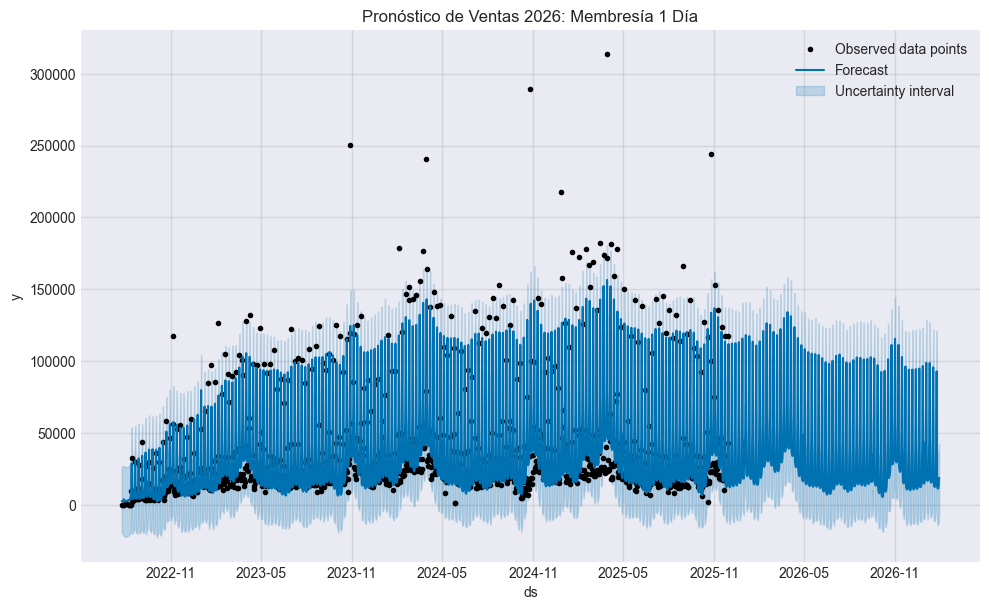

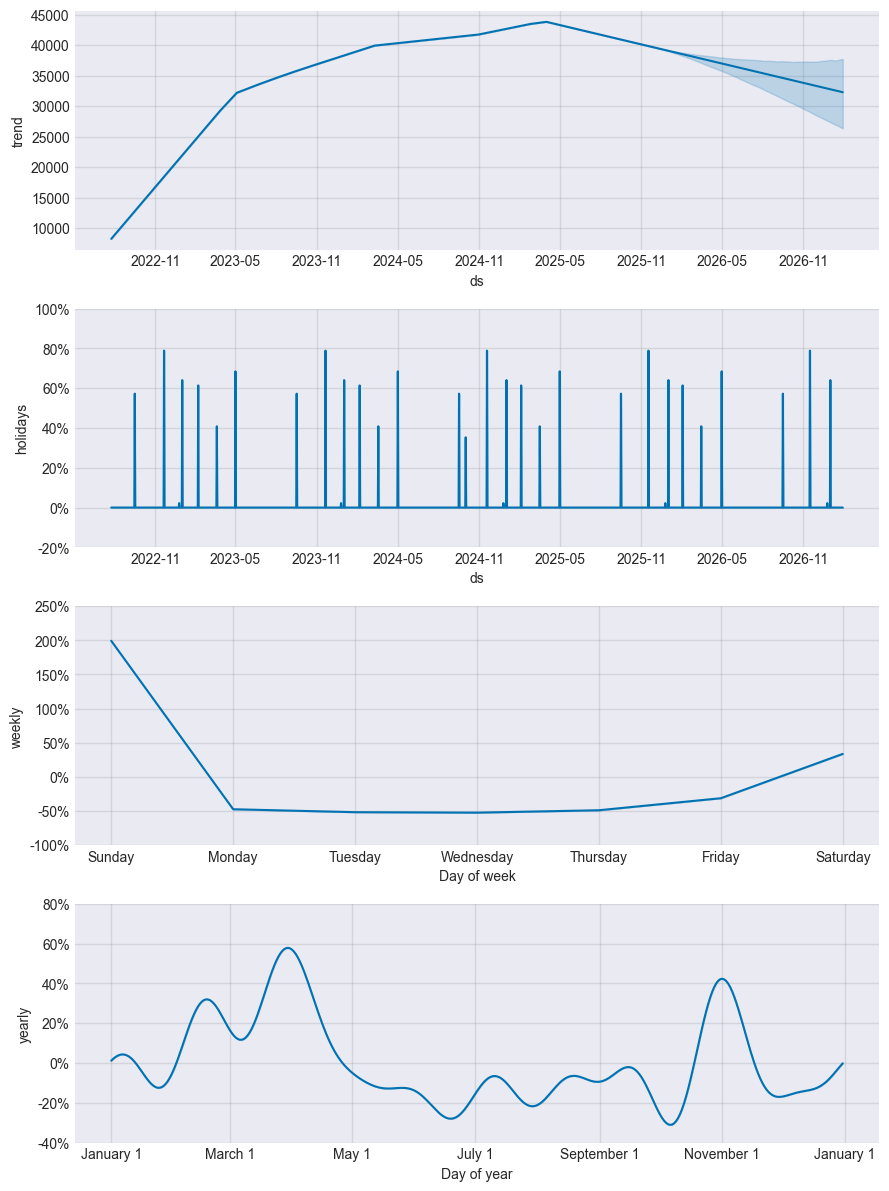

In [7]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas 2026: Membresía 1 Día")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [8]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(2).reset_index()
print(monthly_sales)

      month        yhat  yhat_lower  yhat_upper
0   2022-07     9235.17   -61455.34    80394.73
1   2022-08   212003.18  -357636.83   791933.12
2   2022-09   346271.70  -368934.30  1062230.42
3   2022-10   499093.74  -241453.44  1244696.05
4   2022-11   579917.13  -146142.93  1295405.39
5   2022-12   555585.22  -179881.35  1298084.91
6   2023-01   729397.02    -5832.58  1477527.19
7   2023-02   886520.26   216181.50  1556871.58
8   2023-03  1127781.55   375238.87  1876792.15
9   2023-04  1219550.20   505819.06  1932754.86
10  2023-05   870564.06   122169.94  1604061.40
11  2023-06   751224.68    39110.78  1463771.75
12  2023-07   983452.92   235908.32  1720954.34
13  2023-08   910604.05   174984.11  1658617.51
14  2023-09  1008827.78   293569.75  1723052.04
15  2023-10  1137655.49   399964.61  1883136.12
16  2023-11  1214608.13   498614.45  1932584.05
17  2023-12  1117644.16   376939.87  1855513.16
18  2024-01  1121698.49   383039.28  1863441.10
19  2024-02  1376968.48   689351.86  206

In [9]:
monthly_sales.to_csv("../data/data_forecast_2026/data_forecast_2026_gold/forecast_1_dia_2026_monthly.csv")

In [10]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/3 [00:00<?, ?it/s]17:00:27 - cmdstanpy - INFO - Chain [1] start processing
17:00:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.29it/s]17:00:27 - cmdstanpy - INFO - Chain [1] start processing
17:00:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.72it/s]17:00:28 - cmdstanpy - INFO - Chain [1] start processing
17:00:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

  horizon          rmse      mape
0  9 days   9474.317179  0.292017
1 10 days  11346.332800  0.285463
2 11 days  12315.141671  0.276221
3 12 days  12602.631302  0.265051
4 13 days  12972.595521  0.281087
